# MIMIC IV CNN Evaluation

### Set Up 

In [6]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, average_precision_score, precision_recall_curve, auc
from tableone import TableOne

**Column Definitions**
- subject_id: *patient unique identifier*
- study_id: *study of patient (x-ray instance)*
- dicom_id: *individual image ID*
- split: *train-validate-test split*
- path: *image path*
- hadm_id: *hospital admission id*
- admittime: *time of hospital admission*
- dischtime: *time of hospital discharge*
- deathtime: *time of death*
- admission_type: *admission type*
- admission_location: *admission location*
- discharge_location: *discharge location* 
- insurance: *patient's insurance type [Medicaid, Medicare, Other (private)]*
- language: *patient's native language*
- marital_status: *patient's marital status*
- race: *patient's race*
- edregtime: *in time of ER admittance*
- edouttime: *out time of ER admittance*
- hospital_expire_flag: *whether they died or not*
- gender: *patient's gender*
- anchor_age: *age*
- anchor_year: *shifted year by same delta*
- anchor_year_group: *bins of shifted years*
- dod: *death of death*
- Diagonses (values[-1.0, 0.0, 1.0])
    - Atelectasis
    - Cardiomegaly
    - Consolidation
    - Edema
    - Enlarged Cardiomediastinum
    - Fracture
    - Lung Lesion
    - Lung Opacity
    - No Finding
    - Pleural Effusion
    - Pleural Other
    - Pneumonia
    - Pneumothorax
    - Support Devices
- Probability of Diagnosis (0,1)
    - pred_Atelectasis
    - pred_Cardiomegaly
    - pred_Consolidation
    - pred_Edema
    - pred_Enlarged Cardiomediastinum
    - pred_Fracture
    - pred_Lung Lesion
    - pred_Lung Opacity
    - pred_No Finding
    - pred_Pleural Effusion
    - pred_Pleural Other
    - pred_Pneumonia
    - pred_Pneumothorax
    - pred_Support Devices

    

In [7]:
results_baseline = pd.read_csv('../runs/run1/results.csv')
results_focal = pd.read_csv('../runs/run4/results_focal_loss.csv')
admissions = pd.read_csv('/home/zzaiman/local/physionet.org/files/mimiciv/2.0/hosp/admissions.csv')
patients = pd.read_csv('/home/zzaiman/local/physionet.org/files/mimiciv/2.0/hosp/patients.csv')

In [8]:
# Filter for just frontal results.
focal_did = results_focal['dicom_id'].unique()
results_baseline = results_baseline[results_baseline['dicom_id'].isin(focal_did)].reset_index(drop=True)

In [9]:
assert results_baseline.shape[0] == results_focal.shape[0]

In [10]:
results_baseline = results_baseline.merge(admissions, on='subject_id')
results_baseline = results_baseline.merge(patients, on='subject_id')
results_baseline.head()

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,...,marital_status,race,edregtime,edouttime,hospital_expire_flag,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10046166,50051329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,MARRIED,WHITE,2132-12-06 09:52:00,2132-12-06 12:56:00,0,M,67,2132,2011 - 2013,2133-11-04
1,10046166,50051329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,MARRIED,OTHER,2133-09-19 18:15:00,2133-09-20 04:48:00,0,M,67,2132,2011 - 2013,2133-11-04
2,10046166,50051329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,MARRIED,WHITE,NaN,NaN,0,M,67,2132,2011 - 2013,2133-11-04
3,10046166,50051329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,MARRIED,WHITE,2133-03-21 10:23:00,2133-03-21 19:57:00,0,M,67,2132,2011 - 2013,2133-11-04
4,10046166,50051329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,MARRIED,OTHER,2133-10-05 23:43:00,2133-10-06 16:09:00,0,M,67,2132,2011 - 2013,2133-11-04


In [11]:
results_baseline.columns

Index(['subject_id', 'study_id', 'Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture',
       'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
       'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices',
       'dicom_id', 'split', 'path', 'pred_Atelectasis', 'pred_Cardiomegaly',
       'pred_Consolidation', 'pred_Edema', 'pred_Enlarged Cardiomediastinum',
       'pred_Fracture', 'pred_Lung Lesion', 'pred_Lung Opacity',
       'pred_No Finding', 'pred_Pleural Effusion', 'pred_Pleural Other',
       'pred_Pneumonia', 'pred_Pneumothorax', 'pred_Support Devices',
       'hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type',
       'admission_location', 'discharge_location', 'insurance', 'language',
       'marital_status', 'race', 'edregtime', 'edouttime',
       'hospital_expire_flag', 'gender', 'anchor_age', 'anchor_year',
       'anchor_year_group', 'dod'],
      dtype='object')

### Overall Evaluation

**1. Loss Plots**

Since we are running a multi-class model, we will evaluate our model performance individually on each label. There are multiple ways we can do this. First, we can make loss plots for each label (we are minimizing cross-entropy loss here).

In [12]:
labels = 'Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices'.split(',')
labels = np.array(labels)

In [13]:
preds = pickle.load(open('/local/scratch/zzaiman/CS334FinalProject/zach/runs/run1/predictions', 'rb'))
hist = pickle.load(open('/local/scratch/zzaiman/CS334FinalProject/zach/runs/run1/train_hist', 'rb'))

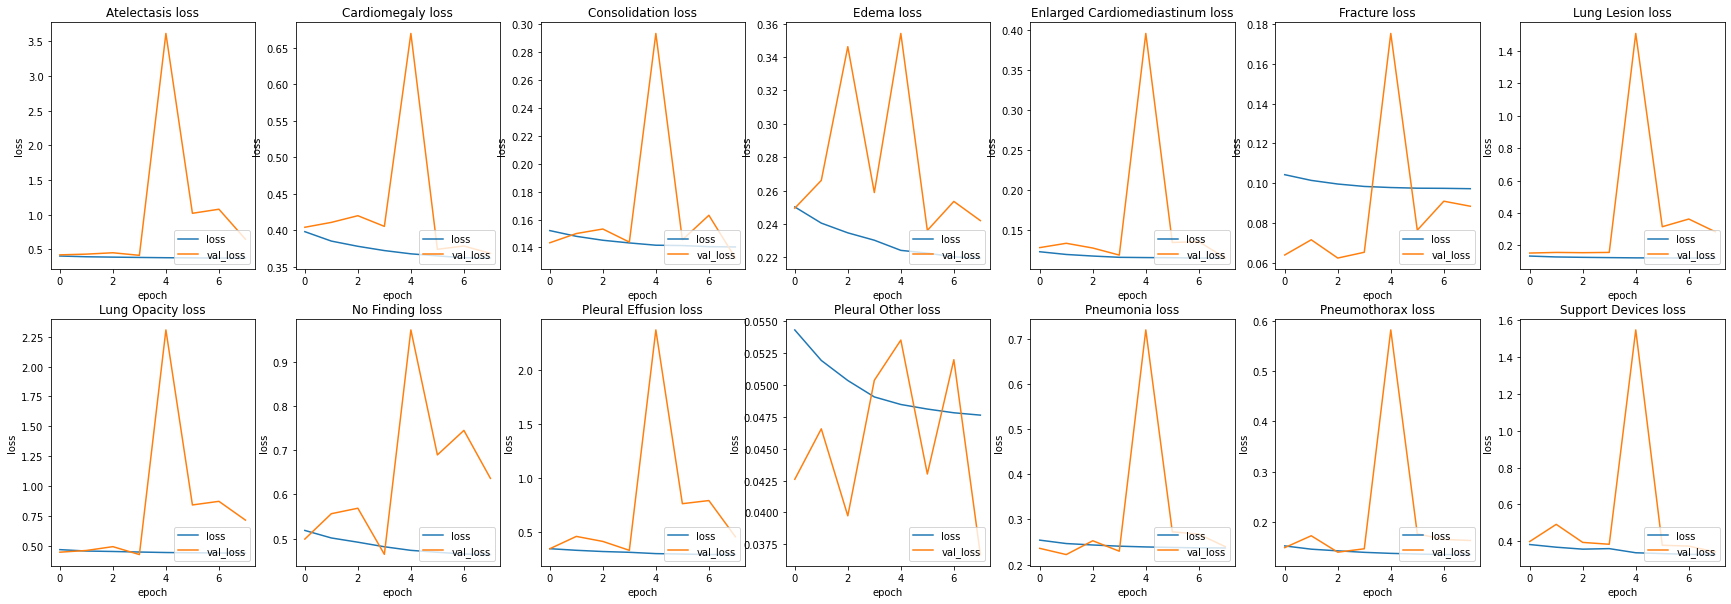

In [14]:
# Loss Plots
fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
for i, lab in enumerate(labels):
    loss = hist[f'dense_{str(i+1)}_loss']
    val_loss = hist[f'val_dense_{str(i+1)}_loss']
    title = f'{lab} loss'

    if i < 7:
        x = 0
    else:
        x = 1
    
    if i < 7:
        y = i
    else:
        y = i - 7

    ax[x, y].plot(loss, label='loss')
    ax[x, y].plot(val_loss, label='val_loss')
    ax[x, y].title.set_text(title)
    ax[x, y].legend(loc=4)
    ax[x, y].set_xlabel('epoch')
    ax[x, y].set_ylabel('loss')

**2. AUROC**

The second way we can assess our model performance is by plotting the AUROC curve for each label. We can find the overall AUC values for each label as well.

In [15]:
# Calculates the AUROC or PRAUC score.
def calc_overall_auc(df, labels, callback):
    auc = {}
    for lab in labels:
        ytrue = df[lab]
        ypred = df['pred_'+lab]
        tauc = callback(ytrue, ypred)
        auc[lab] = tauc

    return auc


In [16]:
# Overall ROCAUC Scores for the baseline model.
roc_overall_baseline = calc_overall_auc(results_baseline, labels, roc_auc_score)
roc_overall_baseline

{'Atelectasis': 0.7431400674780572,
 'Cardiomegaly': 0.7546333741915257,
 'Consolidation': 0.6805090322998756,
 'Edema': 0.8115940720183094,
 'Enlarged Cardiomediastinum': 0.6989383323719662,
 'Fracture': 0.6654504696023263,
 'Lung Lesion': 0.7109029416250601,
 'Lung Opacity': 0.6326384169478843,
 'No Finding': 0.7836550952426761,
 'Pleural Effusion': 0.8691560775267628,
 'Pleural Other': 0.7782776642444974,
 'Pneumonia': 0.6403912316936494,
 'Pneumothorax': 0.6731104860460795,
 'Support Devices': 0.8390208459492183}

In [17]:
# Overall ROCAUC Scores for the baseline model.
roc_overall_focal = calc_overall_auc(results_focal, labels, roc_auc_score)
roc_overall_focal

{'Atelectasis': 0.7001397681574608,
 'Cardiomegaly': 0.6987550928827854,
 'Consolidation': 0.7039280666120277,
 'Edema': 0.7885108942517168,
 'Enlarged Cardiomediastinum': 0.6438360719035565,
 'Fracture': 0.6597704615725912,
 'Lung Lesion': 0.6772301710809273,
 'Lung Opacity': 0.6569517047362785,
 'No Finding': 0.7706074630246934,
 'Pleural Effusion': 0.8135360034187222,
 'Pleural Other': 0.8474004372207965,
 'Pneumonia': 0.624122854779331,
 'Pneumothorax': 0.7591805766312595,
 'Support Devices': 0.7919805975636953}

In [18]:
# Function to calculate ROC
def calc_roc(df, labels):
    fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
    
    for i, lab in enumerate(labels):
        if i < 7:
            x = 0
        else:
            x = 1
        if i < 7:
            y = i
        else:
            y = i - 7

        otpr, ofpr, _, = roc_curve(df[lab], df['pred_'+lab])
        oauc = roc_auc_score(df[lab], df['pred_'+lab])
        ax[x, y].plot(otpr, ofpr, label=f'Overall auc={round(oauc, 2)}', color='red')
        min = otpr.min()
        ax[x, y].fill_between(otpr,min,ofpr,alpha=0.5, color='red')
        ax[x, y].title.set_text(lab)
        ax[x, y].legend(loc=2)
        ax[x, y].set_xlabel('TPR')
        ax[x, y].set_ylabel('FPR')

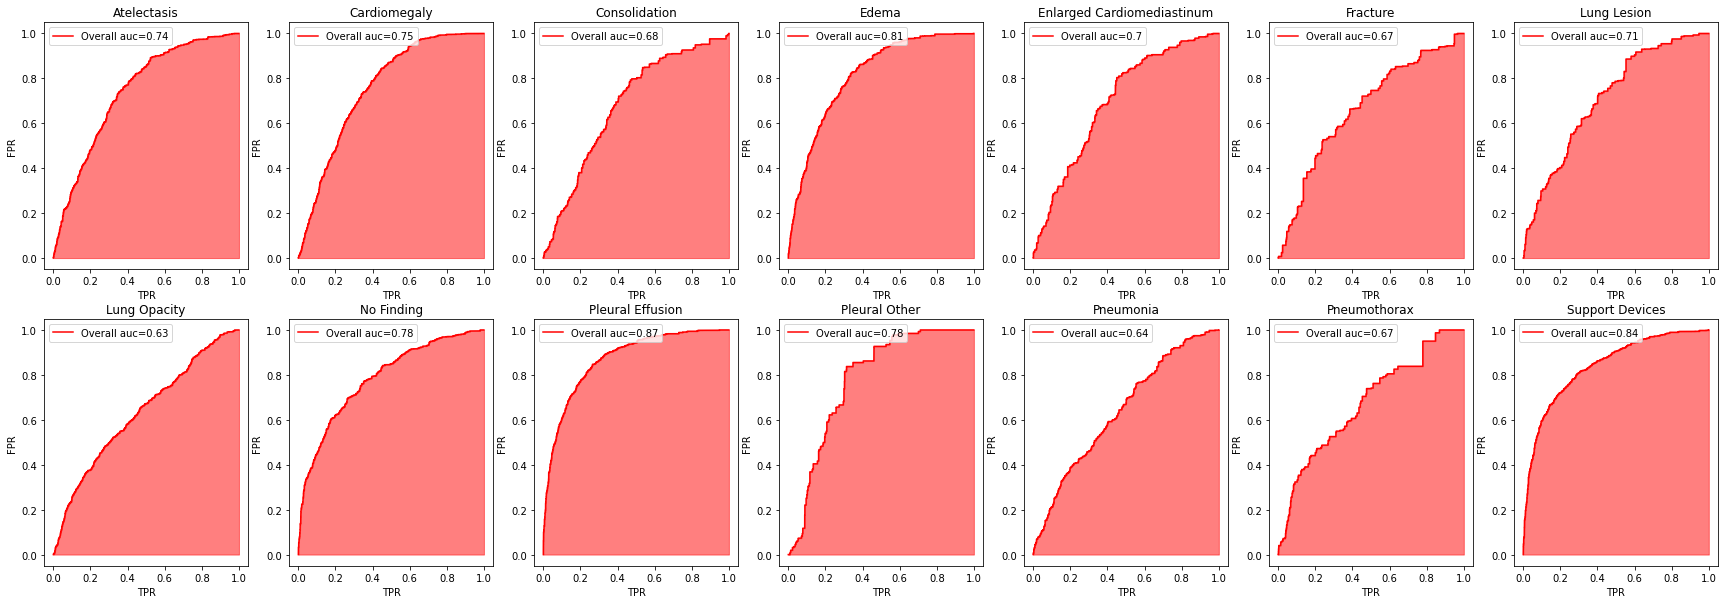

In [19]:
calc_roc(results_baseline, labels)

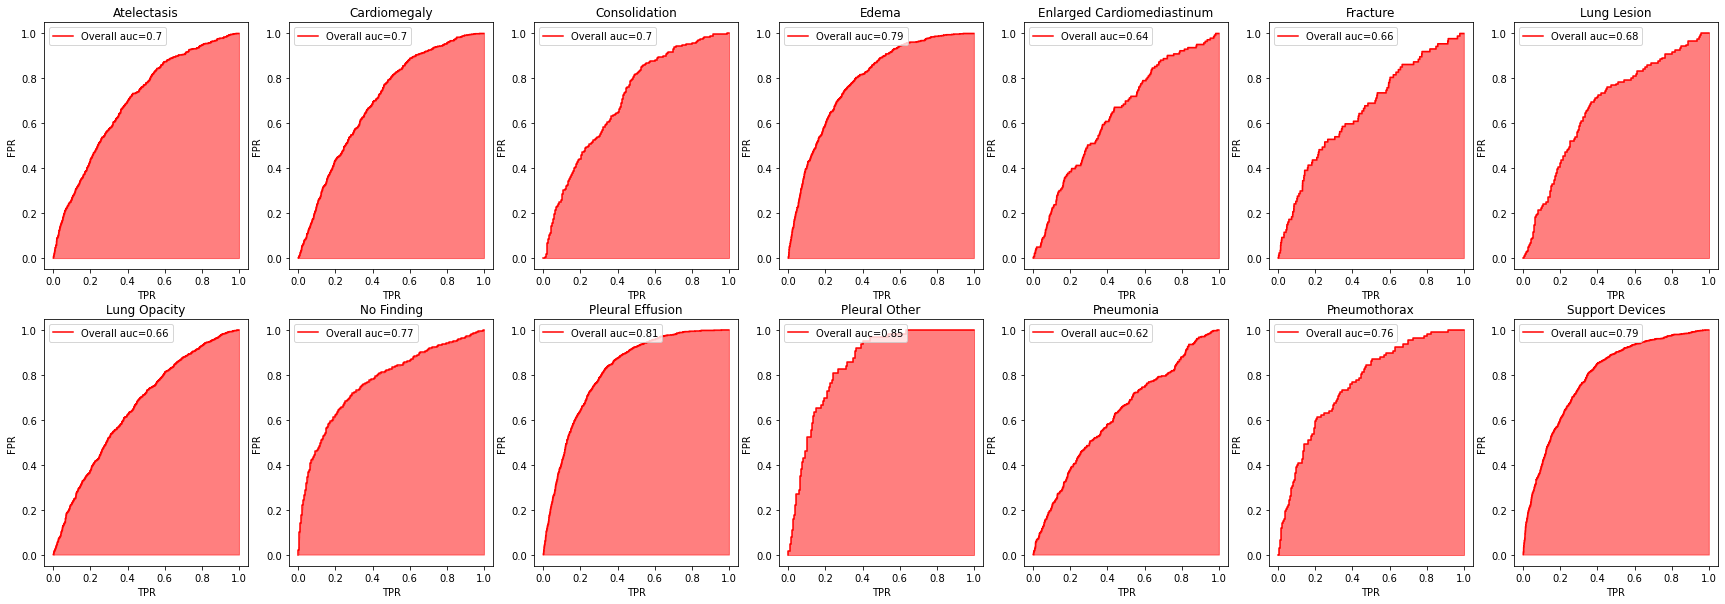

: 

In [ ]:
calc_roc(results_focal, labels)

The above AUROC curves and overall AUC scores for each label are relatively high, indicating good model performance. However we know that there is likely a large class imbalance in this dataset, since only a relatively few number of people will have a lung disease in one of these 14 categories. We can confirm this by looking at the class ratios for each diagonsis label.

In [20]:
lab_imb = {}
for lab in labels:
    a = results_baseline[lab].value_counts()
    ratio = round(a[1.0]/a[0.0],3)
    lab_imb[lab] = ratio

lab_imb

{'Atelectasis': 0.225,
 'Cardiomegaly': 0.39,
 'Consolidation': 0.056,
 'Edema': 0.302,
 'Enlarged Cardiomediastinum': 0.025,
 'Fracture': 0.016,
 'Lung Lesion': 0.029,
 'Lung Opacity': 0.444,
 'No Finding': 0.255,
 'Pleural Effusion': 0.36,
 'Pleural Other': 0.012,
 'Pneumonia': 0.116,
 'Pneumothorax': 0.014,
 'Support Devices': 0.414}

**3. AUPRC**

As we can see from the above dictionary, there is a large class imbalance in every diagnosis label. This means that it is a good idea to also plot AUPRC curves for each diagnosis, since they tend to be more robust against class imbalance.

In [21]:
# Overall Average Precision Score on baseline.
auprc_overall_baseline = calc_overall_auc(results_baseline, labels, average_precision_score)
auprc_overall_baseline

{'Atelectasis': 0.35876487813238966,
 'Cardiomegaly': 0.4746927009587062,
 'Consolidation': 0.09212398921318823,
 'Edema': 0.5383779202334161,
 'Enlarged Cardiomediastinum': 0.06069264190983514,
 'Fracture': 0.028643846474306477,
 'Lung Lesion': 0.07073010666955865,
 'Lung Opacity': 0.4294235267495115,
 'No Finding': 0.5303928505822353,
 'Pleural Effusion': 0.7194723280561842,
 'Pleural Other': 0.027356189661780054,
 'Pneumonia': 0.1764927841755227,
 'Pneumothorax': 0.03513494162972687,
 'Support Devices': 0.7058473814060992}

In [22]:
auprc_overall_focal = calc_overall_auc(results_focal, labels, average_precision_score)
auprc_overall_focal

{'Atelectasis': 0.38975509793693197,
 'Cardiomegaly': 0.40459262874225227,
 'Consolidation': 0.12199634465491686,
 'Edema': 0.4746718961554023,
 'Enlarged Cardiomediastinum': 0.06902804519885383,
 'Fracture': 0.05388161086056074,
 'Lung Lesion': 0.064193755242209,
 'Lung Opacity': 0.45247661400200256,
 'No Finding': 0.484493383554459,
 'Pleural Effusion': 0.6271158507060988,
 'Pleural Other': 0.0793804239724488,
 'Pneumonia': 0.16171549488576853,
 'Pneumothorax': 0.09506068079734362,
 'Support Devices': 0.661051520780422}

In [23]:
def calc_auprc(df, labels):
    fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
    
    for i, lab in enumerate(labels):
        if i < 7:
            x = 0
        else:
            x = 1
        if i < 7:
            y = i
        else:
            y = i - 7

        opre, orec, _ = precision_recall_curve(df[lab], df['pred_'+lab])
        avg_pre = average_precision_score(df[lab], df['pred_'+lab])
        ax[x, y].plot(orec, opre, label=f'Average Precision={round(avg_pre, 2)}')
        min = opre.min()
        ax[x, y].fill_between(orec,min,opre,alpha=0.5)
        ax[x, y].title.set_text(lab)
        ax[x, y].legend(loc=2)
        ax[x, y].set_xlabel('True Positive Rate (Recall)')
        ax[x, y].set_ylabel('Precision')

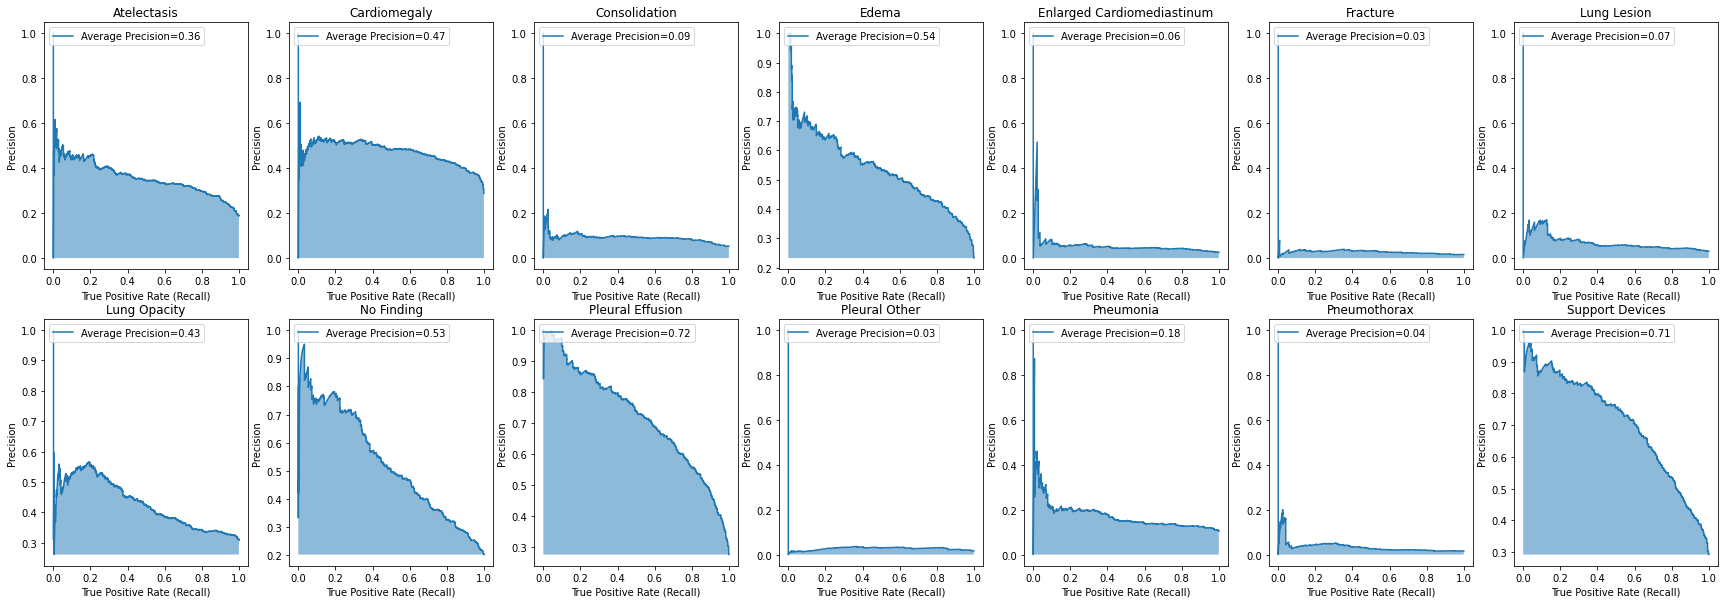

In [24]:
calc_auprc(results_baseline,labels)

The AUPRC curves and overall APC indicate that the model does perform worse on certain diagnosis labels, such as Pleural Other, Enlarged Cardiomediastinum, Fracture, Lung Lesion and Pneumothorax. 

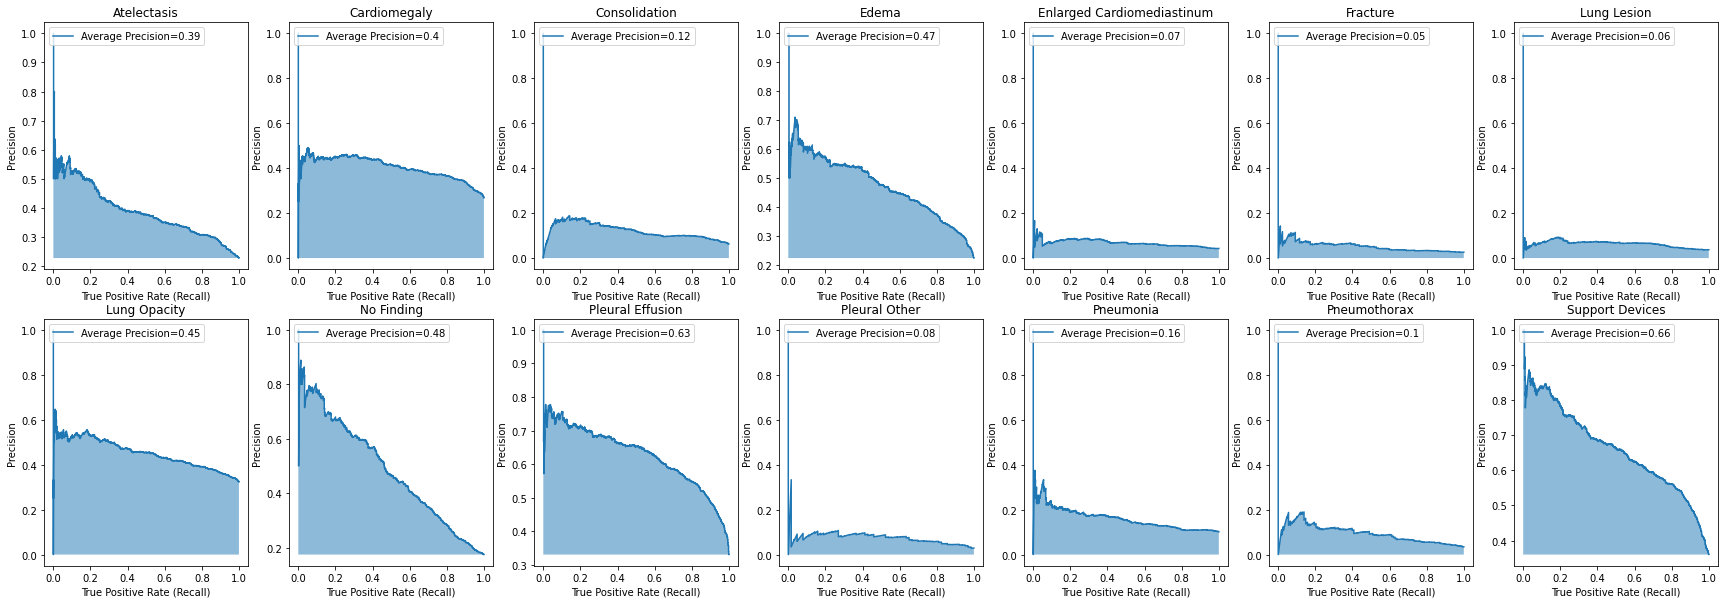

: 

In [ ]:
calc_auprc(results_focal,labels)

In [ ]:
rows = {'rocauc_baseline' : roc_overall_baseline, 'rocauc_focal' : roc_overall_focal, 'auprc_baseline' : auprc_overall_baseline, 'auprc_focal' : auprc_overall_focal}
results_overall = pd.DataFrame(rows.values(), index=rows.keys())
results_overall = results_overall.T

: 

In [25]:
results_overall

NameError: name 'results_overall' is not defined

In [26]:
def calc_performance_overall(df1, df2, labels, callback):
    fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
    
    for i, lab in enumerate(labels):
        if i < 7:
            x = 0
        else:
            x = 1
        if i < 7:
            y = i
        else:
            y = i - 7

        fpr1, tpr1, _ = callback(df1[lab], df1['pred_'+lab])
        fpr2, tpr2, _ = callback(df2[lab], df2['pred_'+lab])

        # Switch the order since precision recall AUC takes parameters in opposite order than ROC AUC.
        if callback == roc_curve:
            auc1 = auc(fpr1, tpr1)
            auc2 = auc(fpr2, tpr2)
        else:
            auc1 = auc(tpr1, fpr1)
            auc2 = auc(tpr2, fpr2)
        
        ax[x, y].plot(fpr1, tpr1, label=f'Baseline AUC={round(auc1, 2)}')
        ax[x, y].plot(fpr2, tpr2, label=f'Focal AUC={round(auc2, 2)}')
        ax[x, y].title.set_text(lab)
        ax[x, y].legend(loc=2)

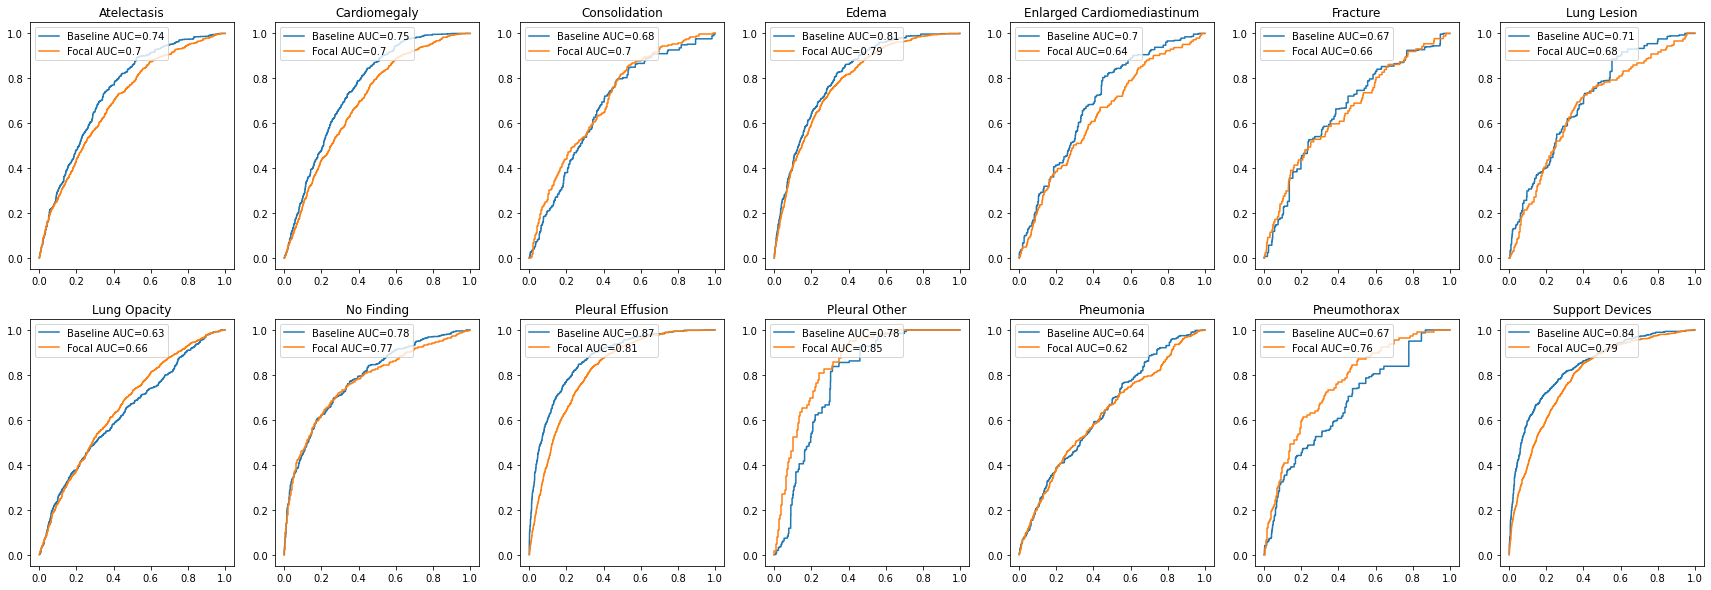

In [27]:
calc_performance_overall(results_baseline, results_focal, labels, roc_curve)

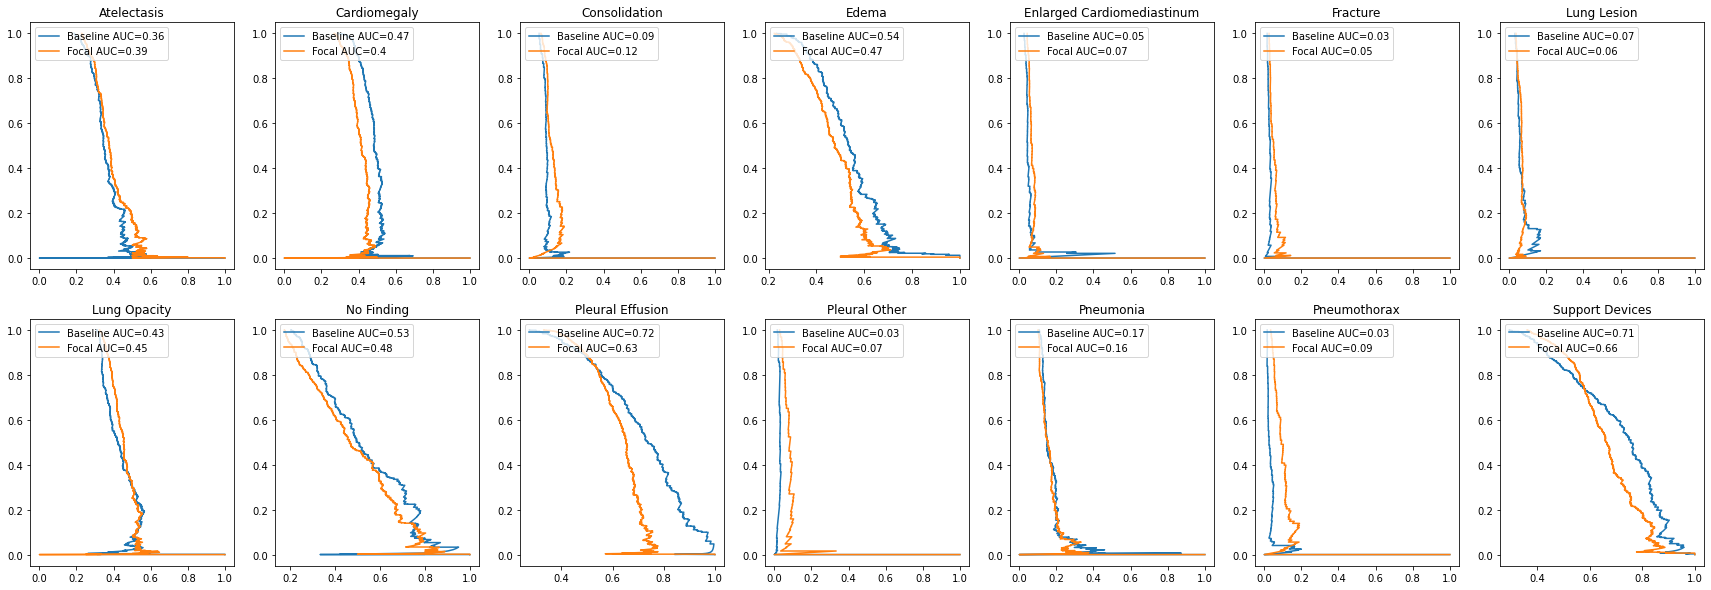

: 

In [ ]:
calc_performance_overall(results_baseline, results_focal, labels, precision_recall_curve)

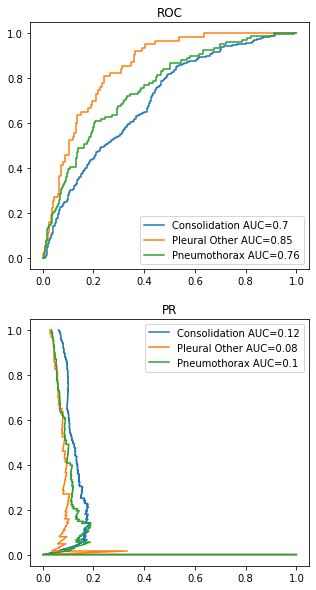

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5, 10))
counter = 0

for lab in ['Consolidation', 'Pleural Other', 'Pneumothorax']:

    fpr1, tpr1, _ = roc_curve(results_focal[lab], results_focal['pred_'+lab])
    auc1 = roc_auc_score(results_focal[lab], results_focal['pred_'+lab])
    ax[0].plot(fpr1, tpr1, label=f'{lab} AUC={round(auc1, 2)}')
    ax[0].title.set_text('ROC')
    ax[0].legend(loc=4)

for lab in ['Consolidation', 'Pleural Other', 'Pneumothorax']:

    fpr1, tpr1, _ = precision_recall_curve(results_focal[lab], results_focal['pred_'+lab])
    auc1 = average_precision_score(results_focal[lab], results_focal['pred_'+lab])
    ax[1].plot(fpr1, tpr1, label=f'{lab} AUC={round(auc1, 2)}')
    ax[1].title.set_text('PR')
    ax[1].legend(loc=1)

## Stratification

We will be stratifying our analysis of the model by a few different relevant features, including race, sex, insurance status (Medicare, Medicaid, Private), ICU status and age.

### 1. Race

#### Pre-Processing

First, we can look at the racial categorization schema of the MIMIC database. We can see that the MIMIC database does not align with US Census categories on race, and includes more specific information on ethnicity. We can also see that white people are heavily overrepresented in the database. 

In [28]:
results_baseline['race'].value_counts()

WHITE                                 33097
BLACK/AFRICAN AMERICAN                12727
HISPANIC/LATINO - PUERTO RICAN         3736
HISPANIC OR LATINO                     2123
BLACK/CAPE VERDEAN                     1781
OTHER                                  1414
ASIAN - SOUTH EAST ASIAN               1146
ASIAN - ASIAN INDIAN                   1144
ASIAN - CHINESE                         877
WHITE - OTHER EUROPEAN                  863
WHITE - EASTERN EUROPEAN                836
BLACK/CARIBBEAN ISLAND                  667
WHITE - RUSSIAN                         299
AMERICAN INDIAN/ALASKA NATIVE           240
SOUTH AMERICAN                          148
PATIENT DECLINED TO ANSWER              138
MULTIPLE RACE/ETHNICITY                 112
UNKNOWN                                  73
HISPANIC/LATINO - CENTRAL AMERICAN       66
HISPANIC/LATINO - GUATEMALAN             35
PORTUGUESE                               18
UNABLE TO OBTAIN                         12
HISPANIC/LATINO - DOMINICAN     

This is why we can bucket the races. This will prevent some buckets, particularly of minority patients, of being too small relative to the number of white patients and will also facilitate our data analysis process. The buckets we will choose are:

    * White
    * Asian + Pacific Islander 
    * Hispanic/Latino
    * Black/African American
    * Unknown/Other (including Native American/American Indian, Multiple Ethnicites, Patient Declined to Specify)

In [29]:
# bucket races
def label_races(row):
    if row['race'] in ['BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN', 'BLACK/CARIBBEAN ISLAND']:
        return 'black'
    if row['race'] in ['WHITE', 'WHITE - OTHER EUROPEAN', 'WHITE - EASTERN EUROPEAN', 'WHITE - RUSSIAN', 'PORTUGUESE']:
        return 'white'
    if row['race'] in ['HISPANIC OR LATINO', 'HISPANIC/LATINO - CENTRAL AMERICAN', 'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - DOMINICAN', 'SOUTH AMERICAN']:
        return 'hispanic/latino'
    if row['race'] in ['ASIAN - ASIAN INDIAN', 'ASIAN - KOREAN', 'ASIAN - CHINESE', 'ASIAN', 'ASIAN - SOUTH EAST ASIAN']:
        return 'asian'
    return 'other'

In [30]:
# distribution of new race buckets
results_baseline['race_bucket'] = results_baseline.apply(lambda row: label_races(row), axis=1)
results_baseline['race_bucket'].value_counts()

white              35113
black              15175
hispanic/latino     6118
asian               3176
other               1989
Name: race_bucket, dtype: int64

#### Evaluation

The first thing we will do is look at the distribution of records by race bucket for each of the 14 diagonses. This will help us get a better sense of what diagnoses are more commonly found in certain race buckets. 

*It is important to note that there is a lot of literature both for and against the idea that American conceptions of race are actually linked to any kind of genetic variation that impacts health, or if race is simply a proxy for a confluence of socioeconomic factors that contribute to health disparities. This project will not presume either orientation/explanation, but will simply analyze correlations between the model diagnoses at hand and designated Census-backed racial categories.*

In [31]:
# filter on relevant rows
race_dist_df = results_baseline.filter(['subject_id', 'race_bucket', 'Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Enlarged Cardiomediastinum',
       'Fracture', 'Lung Lesion', 'Lung Opacity',
       'No Finding', 'Pleural Effusion', 'Pleural Other',
       'Pneumonia', 'Pneumothorax', 'Support Devices' ], axis=1)

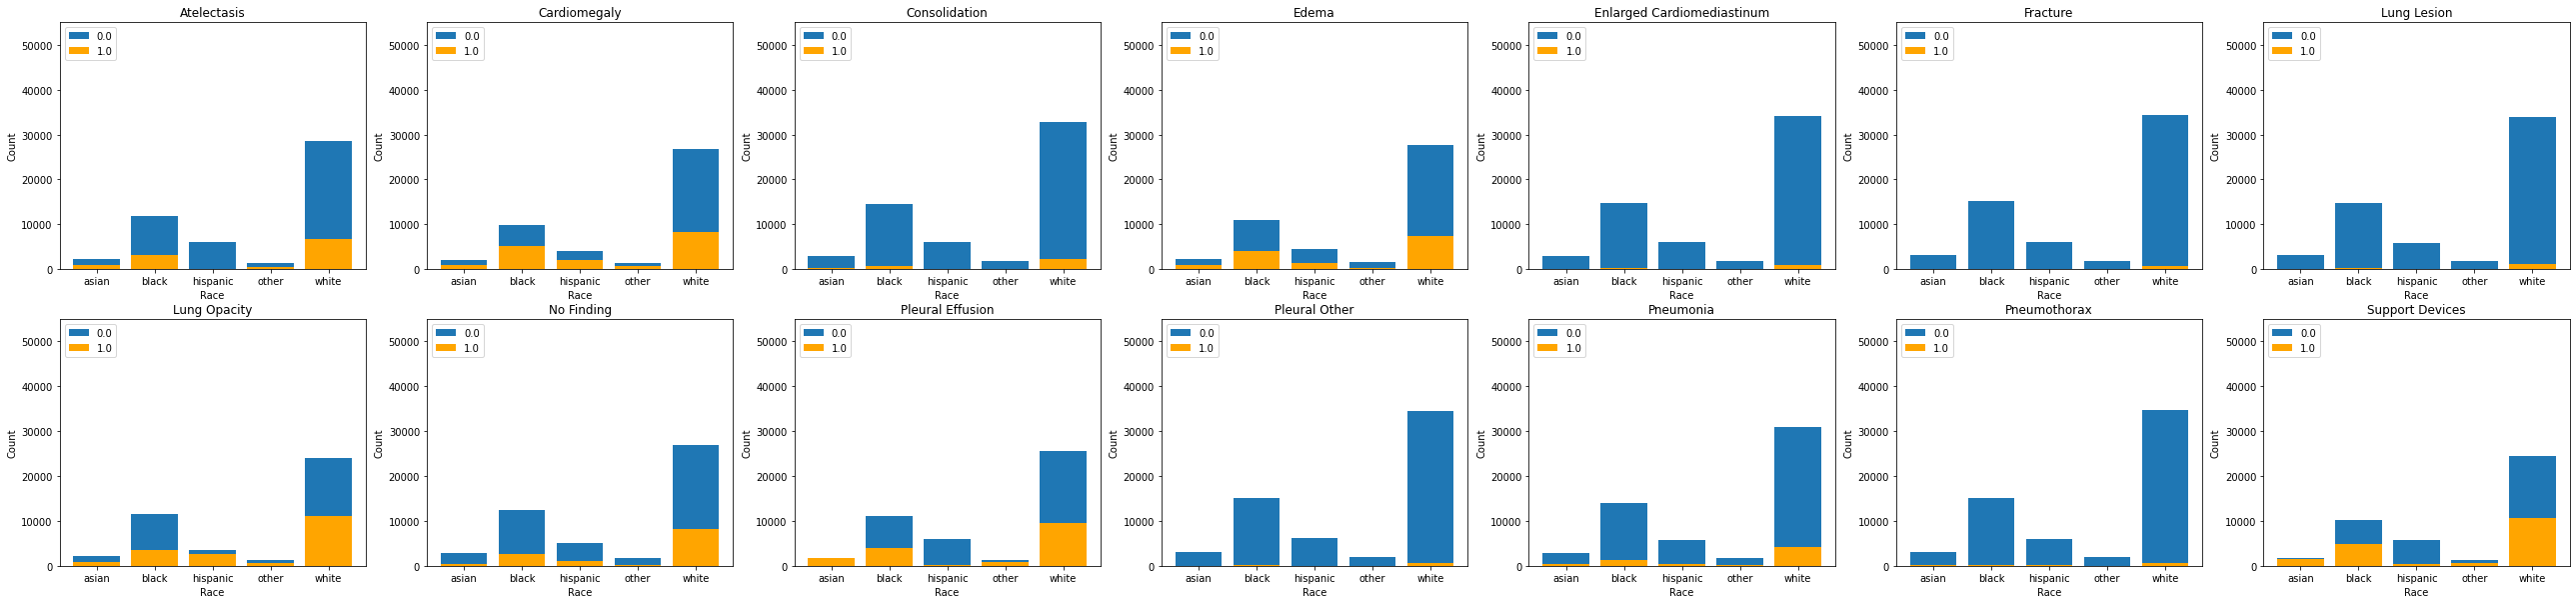

In [32]:
from matplotlib import ticker
fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(45, 10))
races = ['asian', 'black', 'hispanic', 'other', 'white']
positions = [0,1,2,3,4]
for i, lab in enumerate(labels):
    if i < 7:
        x = 0
    else:
        x = 1
    if i < 7:
        y = i
    else:
        y = i - 7

    a = pd.DataFrame({'count': race_dist_df.groupby([lab, 'race_bucket']).size()}).reset_index()
    neg_df = a[a[lab] == 0.0].iloc[:, 1:]
    pos_df = a[a[lab] == 1.0].iloc[:, 1:]
    ax[x,y].bar(neg_df.iloc[:,0], neg_df.iloc[:,1], label='0.0')
    ax[x,y].bar(pos_df.iloc[:,0], pos_df.iloc[:,1], color='orange', label='1.0')
    ax[x, y].title.set_text(lab)
    ax[x, y].legend(loc=2)
    ax[x, y].xaxis.set_major_locator(ticker.FixedLocator(positions))
    ax[x, y].xaxis.set_major_formatter(ticker.FixedFormatter(races))
    ax[x, y].set_xticklabels(races)
    ax[x, y].set_xlabel('Race')
    ax[x, y].set_ylabel('Count')
    ax[x, y].set_ylim(0,55000)
    

The next think we can do is look at the AUROC for each race-diagnosis combination, resulting in a multi-line plot for each diagnosis label.

In [33]:
# Helper functions for evaluating model performance
# Generate 95% Confidence Intervals for each AUC score
def generate_CI(y_true, y_pred):

    n_bootstraps = 1000
    rng_seed = 2021  
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            continue

        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    #95% confidence interval
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    ci_str = '[{}, {}]'.format(str(round(confidence_lower, 3)), str(round(confidence_upper, 3)))
    return ci_str

# Calculate and plot ROC
def calc_roc(df, strata, labels):
    fpr = {}
    tpr = {}
    auc = {}
    fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
    for i, lab in enumerate(labels):
        if i < 7:
            x = 0
        else:
            x = 1
        if i < 7:
            y = i
        else:
            y = i - 7
        otpr, ofpr, _, = roc_curve(df[lab], df['pred_'+lab])
        oauc = roc_auc_score(df[lab], df['pred_'+lab])
        ci = generate_CI(df[lab], df['pred_'+lab])
        ax[x, y].plot(otpr, ofpr, label=f'Overall auc={round(oauc, 2)} ci={ci}')
        for category in df[strata].unique():
            tmp = df[df[strata] == category].reset_index(drop=True)
            ytrue = tmp[lab]
            if len(np.unique(ytrue)) == 1:
                print(f"Dropped strata: {category} in class {lab}", flush=True)
                continue

            ypred = tmp['pred_'+lab]
            tfpr, ttpr, _ = roc_curve(ytrue, ypred)
            tauc = roc_auc_score(ytrue, ypred)
            fpr[str(category) + '_' + lab] = tfpr
            tpr[str(category) + '_' + lab] = ttpr
            auc[str(category) + '_' + lab] = tauc
            tci = generate_CI(ytrue, ypred)
            ax[x, y].plot(tfpr, ttpr, label=f'{str(category)} auc={round(tauc, 2)}, ci={tci}')
            ax[x, y].title.set_text(lab)
            ax[x, y].legend(loc=4)
            ax[x, y].set_xlabel('FPR')
            ax[x, y].set_ylabel('TPR')

Dropped strata: asian in class Pleural Other


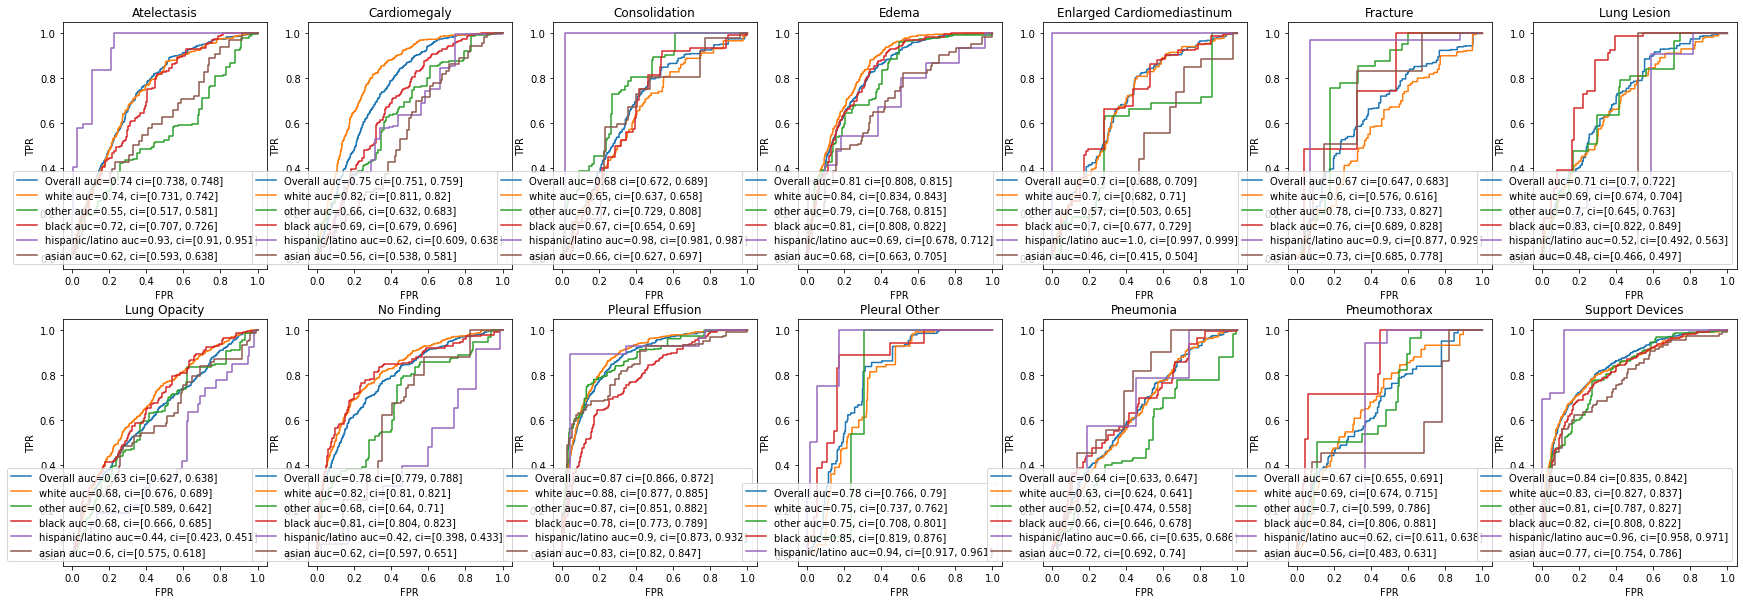

In [34]:
calc_roc(results_baseline, 'race_bucket', labels)

In [35]:
# Nested Table showing model performance per race-diagnosis combination

### 2. ICU Status

Another feature we wanted to stratify by is the ICU status of the patient. Generally, patients who are in the ICU tend to have more severe diagnoses, so we wanted to see if the model would perform better on ICU patients' x-rays compared to non-ICU patients.

In [36]:
icu = pd.read_csv('/home/zzaiman/local/physionet.org/files/mimiciv/2.0/icu/icustays.csv')
metadata = pd.read_csv('../../../physionet.org/files/mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-metadata.csv')

In [37]:
# Filter metadata to get StudyDate
metadata = metadata[['subject_id', 'study_id', 'StudyDate']]

# Convert dates to datetime. 
metadata['StudyDate'] = pd.to_datetime(metadata['StudyDate'], format='%Y%m%d')
icu['intime'] = pd.to_datetime(icu['intime'])
icu['outtime'] = pd.to_datetime(icu['outtime'])

# Merge with ICU and filter for all study dates in an ICU stay for the same patient.
metadata_icu = metadata.merge(icu, on='subject_id')
metadata_icu = metadata_icu[(metadata_icu['StudyDate'] >= metadata_icu['intime']) & (metadata_icu['StudyDate'] <= metadata_icu['outtime'])].reset_index(drop=True)


In [38]:
metadata_icu.nunique()

subject_id        10057
study_id          47773
StudyDate         22872
hadm_id           11868
stay_id           12896
first_careunit        8
last_careunit         8
intime            12896
outtime           12896
los               12778
dtype: int64

In [39]:
# Drop duplicates on study ID since all patients in this df are in the ICU.
metadata_icu = metadata_icu.drop_duplicates(subset=['study_id'])
metadata_icu.shape

(47773, 10)

In [40]:
metadata_icu['study_in_icu'] = 1
metadata_icu_studies = metadata_icu[['study_id', 'study_in_icu']]
results_icu = results_baseline.merge(metadata_icu_studies, on='study_id', how='left')
results_icu['study_in_icu'].fillna(0, inplace=True)
results_icu['study_in_icu'].value_counts()

0.0    49033
1.0    12538
Name: study_in_icu, dtype: int64

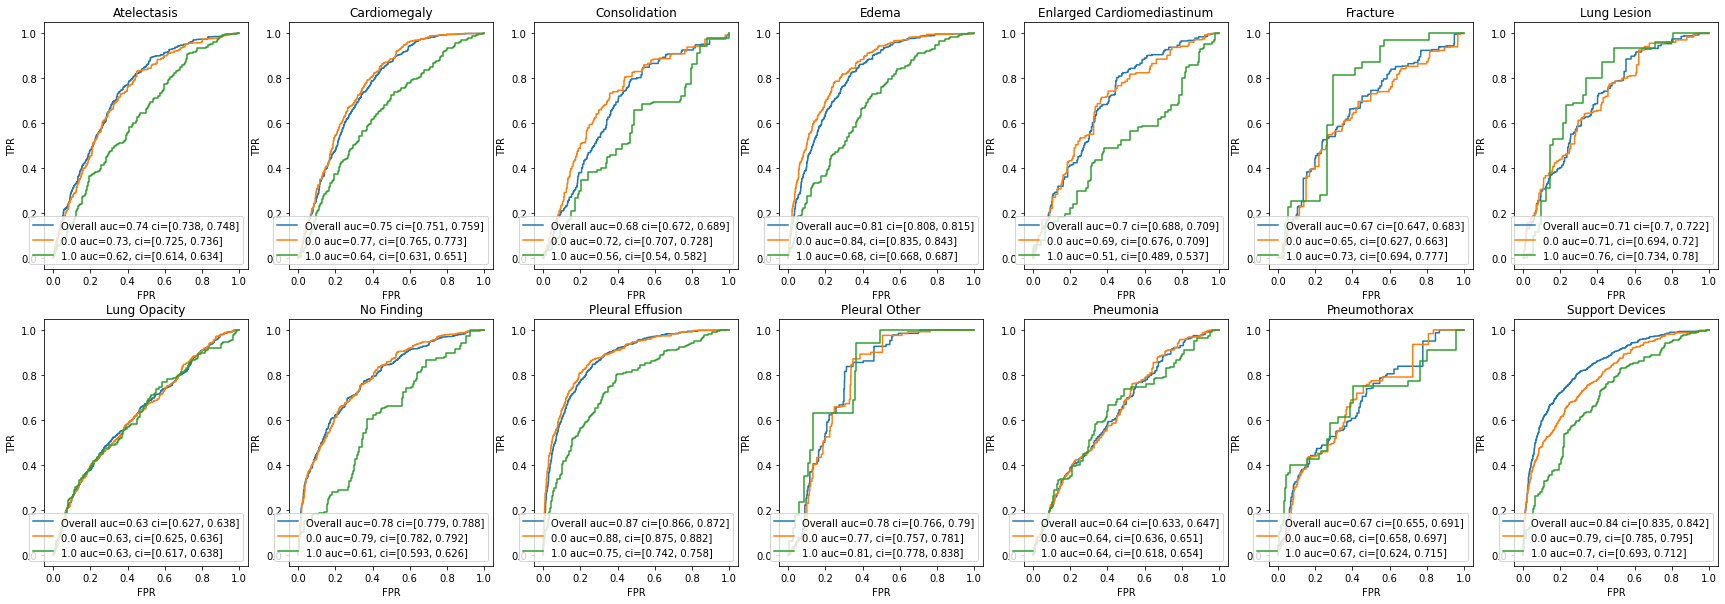

In [41]:
calc_roc(results_icu, 'study_in_icu', labels)

We can also view the same result in table format, as seen below.

In [42]:
cols = list(labels)
cat = list(labels)
groupby = 'study_in_icu'
tab = TableOne(results_icu, columns=cols, categorical=cat, groupby=groupby, missing=False, pval=True)